In [185]:
#%%

# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'


# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## I/O
import zipfile
import requests
import pickle

## FUNCTIONS AND CLASSES

# Normalization function
def norm(vec):
    '''
    Normalizes a vector v-v.mean())/v.std() - works for: PandasDataFrame.apply(norm)
    '''
    return (vec-vec.mean())/vec.std()

def nrmcol(df):
    '''
    Normalizes the columns of a DataFrame (cos distance)
    '''
    return df / np.sqrt(np.diagonal(df.T @ df))

# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socpnr,shave=5):
    '''
    Key function 
        1. formats SOC-occupation codes – for matching O*Net and census.
        2. 'Shaves' the SOC-number to length 'shave'. The number sets the granularity of job classifications. 
    '''
    socpnr2 = str(socpnr).replace('-','')
    socp_shave = socpnr2[:shave]
    return socp_shave


#
class   Onet:
    def __init__(self,features):
        self.features = features
        self.data = self.get_data()
        self.matrix = self.construct_matrix()

        
    # READ FROM O*NET DATABASE. 
    database = {}
    def get_data(self):
        '''
        READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
        '''
        onet = Onet.database
        if type(self) == Onet:
            featureset = self.features
        else:
            featureset = self
        if featureset in onet:
                return onet[featureset]
        pickle_exists = os.path.isfile('./data/pickle/'+featureset+'.pkl')
        if pickle_exists:
                onet[featureset] = pd.read_pickle('./data/pickle/'+featureset+'.pkl')
                return onet[featureset]
        else: 
                onet[featureset]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+featureset+'.xlsx'))
                onet[featureset].to_pickle('./data/pickle/'+featureset+'.pkl')
                return onet[featureset]
    
   
    def construct_matrix(self):
        '''
        Reshapes O*NET occupation/feature matrix to a regular matrix of N_occupations x M_features. Used as X for fitting. 
        '''
        prepdata = self.prepare()
        foo = pd.get_dummies(prepdata['Element Name']) 
        occ_prepdata = prepdata[['O*NET-SOC Code']].join(foo.multiply(prepdata['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
        occ_prepdata['SOCP'] = occ_prepdata.index
        occ_prepdata['SOCP_shave']=occ_prepdata['SOCP'].apply(soc)
        # Group by census/PUMS SOC codes (SOCP_shave)
        occ_prepdata_compounded= occ_prepdata.groupby('SOCP_shave').mean()
        occ_prepdata_compounded['SOCP_shave'] = occ_prepdata_compounded.index   
        foo = occ_prepdata_compounded.drop(columns='SOCP_shave')
        return foo
  
    def prepare(self):
        '''
        Preprocesses O*Net data for shaping the features x occupations matrix (used as X)
        '''
        df = self.data
        # For Abilities, Knowledge, Skills
        if 'LV' in set(df['Scale ID']):
            sid = 'LV'
        # For Interests
        elif 'OI' in set(df['Scale ID']):
            sid = 'OI'
        df = df[df['Scale ID'] == sid]
        return df[['O*NET-SOC Code','Element Name','Data Value']] 

onet_titles = Onet.get_data('Alternate Titles')
all_SOCP = set(onet_titles['O*NET-SOC Code'])
onet_title_dic = onet_titles[['O*NET-SOC Code','Title']].copy()
onet_title_dic['O*NET-SOC Code'] = onet_title_dic['O*NET-SOC Code'].apply(soc)
onet_socp_name = dict(onet_title_dic.values).get



class   Census:
    '''
    Census is an object containing census ACS/PUMS data for a state (Default = California)
    The original data is read from a pickle file in 'data/pickle/pums_'+state+'.pkl'
    
    my_census.state    – String: name of state, e.g. 'California'
    my_census.data     – DataFrame: imported census ACS/PUMS data (from pickle)
    my_census.workers  – DataFrame: people fulfilling 'workers' criteria (see below)
    my_census.occupations         – DataFrame: Occupations of the workers (groupby SOCP-number)
    my_census.occupations_select: – DataFrame: Occupations fulfilling criteria (see below)
    
    my_census.workers_occupations(age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5):
         - Function: populates my_census.workers / .occupations / .occupations_select according to criteria
             – Workers: age_low (default 40)  and age_high (default 65)
             – Occupations: socp_granularity (default 5) ; the length of the SOCP number, default 5 digits.
             – Occupations_select: std_max
    
    '''

    def __init__(self,state = 'California'):
        self.state = state
        self.data = pd.read_pickle('data/pickle/pums_'+state+'.pkl')
        self.workers_occupations()

    def workers_occupations(self,age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5, dear = False, deye = False):
        '''
        Defines workers as people between ages 'age_low'(default 40) and 'age_high' (default 65)
        Defines occupations as the occupations of these workers, with a granularity of 5 digits in the SOCP number 
        Defines occupations_select as the occupations that have a mean log(FTE wage) with a standard deviation less than 'std_max' (default 0.5)
        '''
        self.workers = self.data[
                            (self.data['AGEP'] >= age_low) &
                            (self.data['AGEP'] <= age_high) 
                        ].copy()
        if dear:
            self.workers = self.workers[self.workers['DEAR']==1]
        if deye:
            self.workers = self.workers[self.workers['DEYE']==1]
        self.workers['log FTE'] = self.workers['FTE wage'].apply(np.log)
        self.workers['SOCP_shave'] = self.workers['SOCP'].apply(lambda socpnr: soc(socpnr,socp_granularity))
        foo = self.workers.groupby('SOCP_shave')
        self.occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
        self.occupations['count'] = foo.count()['AGEP']
        self.occupations['std log FTE'] = foo.std()['log FTE']
        self.occupations['Occupation'] = self.occupations.index
        self.occupations_select = self.occupations[self.occupations['std log FTE'] < std_max]
    
    # Census Data Dictionary
    datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()
        
    # Data Dictionary rows including the string 'word'
    def var_about(word):
        '''
        Census Data dictionary: records containing the string 'word' 
        '''
        datadic = Census.datadic
        return pd.concat((datadic[datadic['Record Type'].apply(lambda x: word.lower() in str(x).lower())],
                      datadic[datadic['Unnamed: 6'].apply(lambda x: word.lower() in str(x).lower())]))

    # Name of occupation for SOCP number
    def socp_name(socp):
        '''
        Census Data dictionary: Name of the occupation(s) corresponding to the input SOCP number 
        '''
        datadic = Census.datadic
        return datadic[datadic['Record Type']== str(socp)]['Unnamed: 6'].values[0]

## OBJECT-ORIENTED FITTING 
class Xfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y, my_regressor, itr, xval) 
            does the following:
            1. SPLITS X and y into test and training sets.
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import r2_score
    import xgboost as xgb  

    def __init__(self,X,y,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
        feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        #self.r2scor = r2_score(ytest,ypred)
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval

In [175]:
## MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        self.on = nrmcol(self.o.T).T
        self.occ = self.on.copy()
        self.occ['Occupations'] = self.occ.index
        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
        self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
        
    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single'): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        sns.clustermap(np.square(self.fn),robust = True, z_score=0,figsize=(
            self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single'):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''   
        sns.clustermap(np.square(self.occ).T, figsize=(
            self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)


class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: features x svd_features
        my_svd.o        - Pandas.DataFrame: occupations x svd_features
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        


#%%
if __name__ == "__main__":      
# # 
# OCCUPATIONAL ARCHETYPES 
# Purpose: A tool for people and organizations to discuss, analyze, predict, strategize on the job market. 
#
# Data Sources:
# - Occupation data: O*NET
# - People data: Census ACS/PUMS
#
# ## What this codes does
# - Creates occupational archetypes from a matrix of occupations and festures (abilities, skills, knowledge, etc.)
# - Selects a demography from census
# - Calculates labor market statistics, economic indicators for the archetypes with regards to the demography
# - Evaluate the predictive power of the Archtypes: 
#       - select a target (yearly full-time equivalent wage)
#       - fit features to target: compare Archetypes vs original features.
# 



    ## CENSUS DATA
    # select workers in ages 40 - 65 and discard the occupations with large standard deviations.

    census = Census('California')

    ## ONET DATA

    ab = Onet('Abilities')
    kn = Onet('Knowledge')
    sk = Onet('Skills')

    # Put them all together in one big feature matrix
    dall = pd.concat([ab.matrix,sk.matrix,kn.matrix],axis = 1)


    ## ESTIMATORS
    rid = linear_model.Ridge(alpha=.5)
    rf = RandomForestRegressor(n_estimators=40,
                            max_features='auto',
                            random_state=0)
    boo = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
    xboo = xgb.XGBRegressor()

In [127]:
census = Census('California')
ab = Onet('Abilities')
kn = Onet('Knowledge')
sk = Onet('Skills')
dall = pd.concat([ab.matrix,sk.matrix,kn.matrix],axis = 1)

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

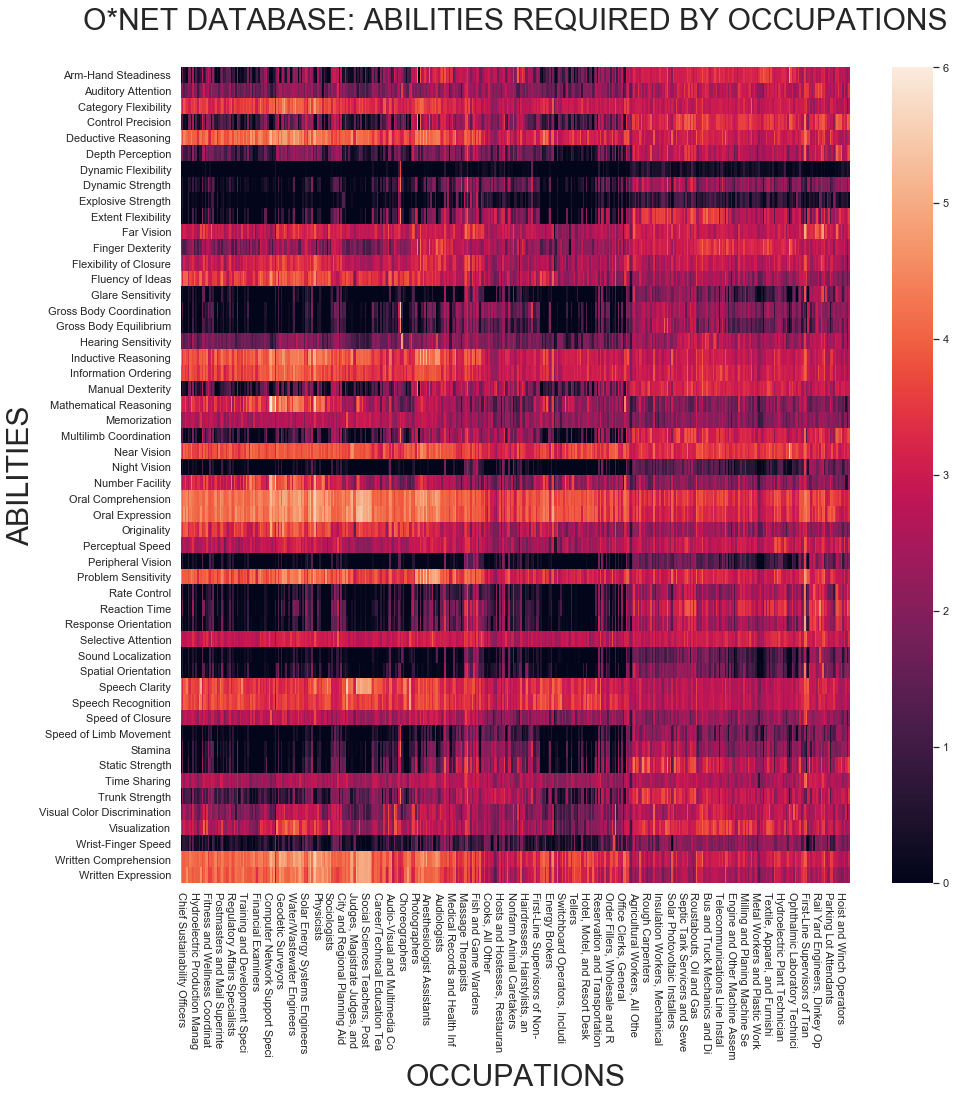

In [43]:
plt.figure(figsize = (15,15))
sns.heatmap(ab.matrix.T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

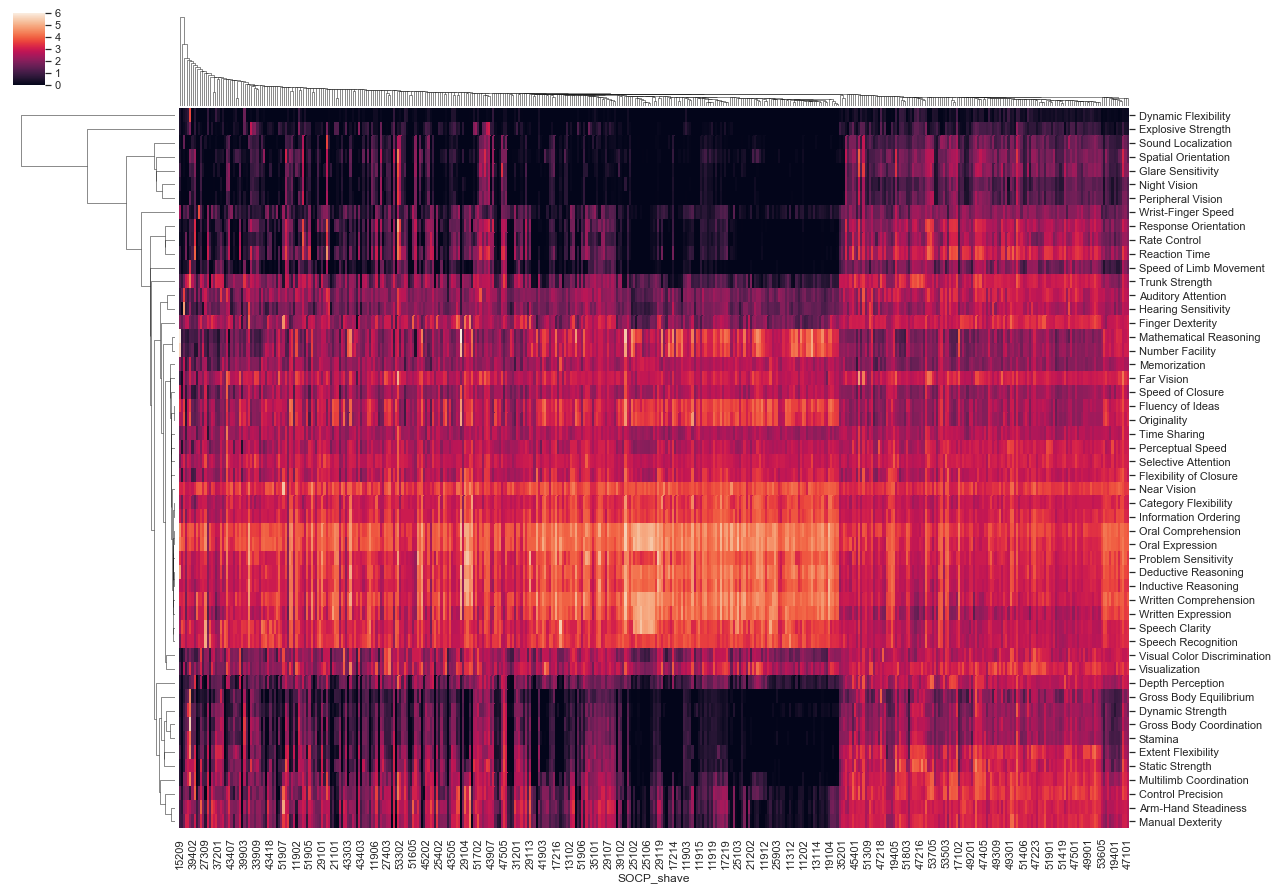

In [123]:
sns.clustermap(ab.matrix.T,figsize = (20,15),method='single',metric='cosine')

In [69]:
abm.shape

(22, 52)

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

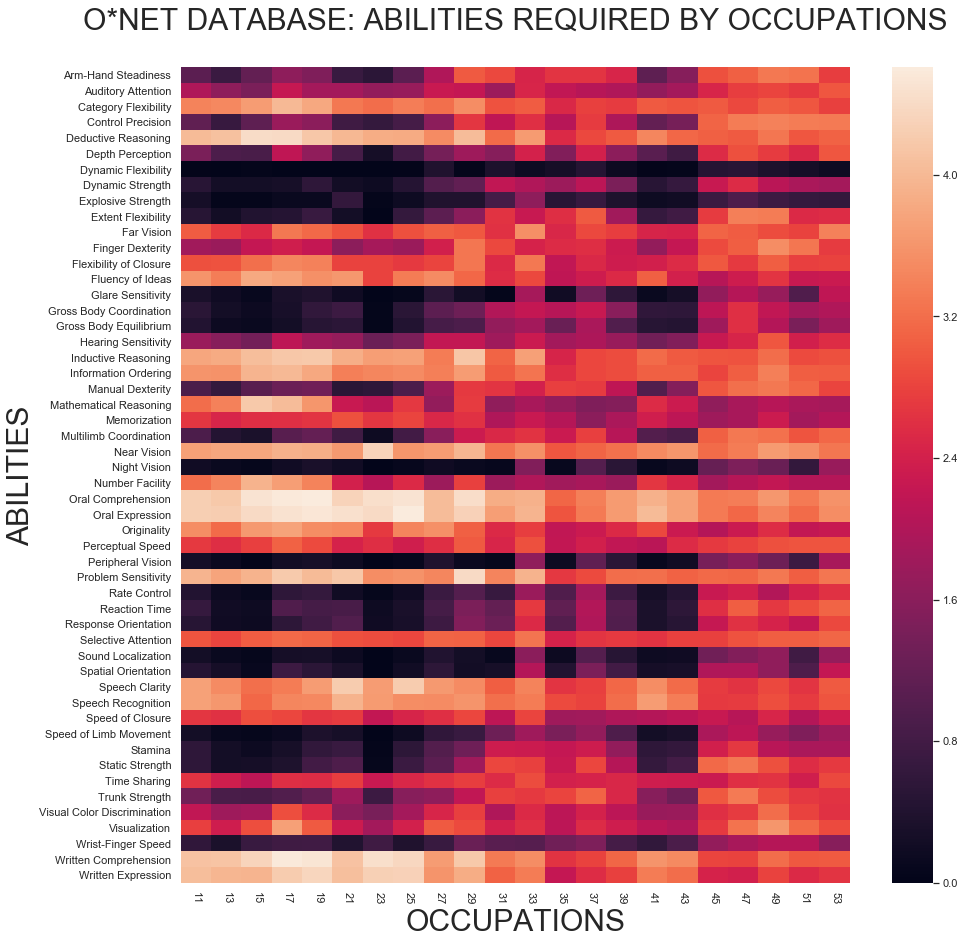

In [127]:
plt.figure(figsize = (15,15))
sns.heatmap(abm.T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

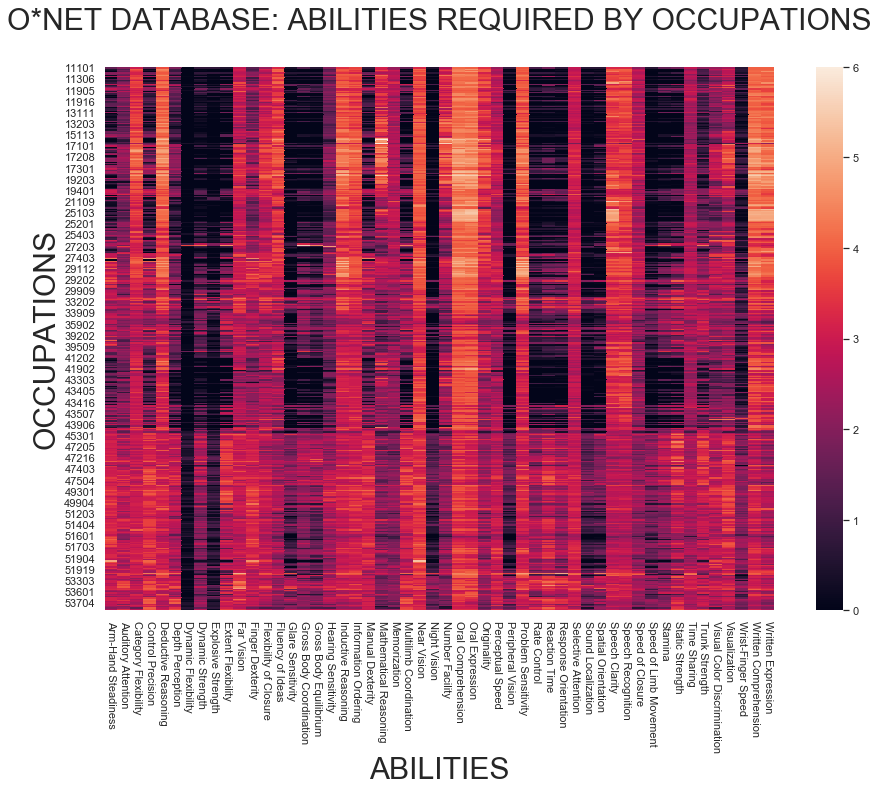

In [133]:
plt.figure(figsize = (15,10))
sns.heatmap(ab.matrix)
plt.xticks(rotation=-90)
plt.xlabel('ABILITIES',fontsize = 30)
plt.ylabel('OCCUPATIONS',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

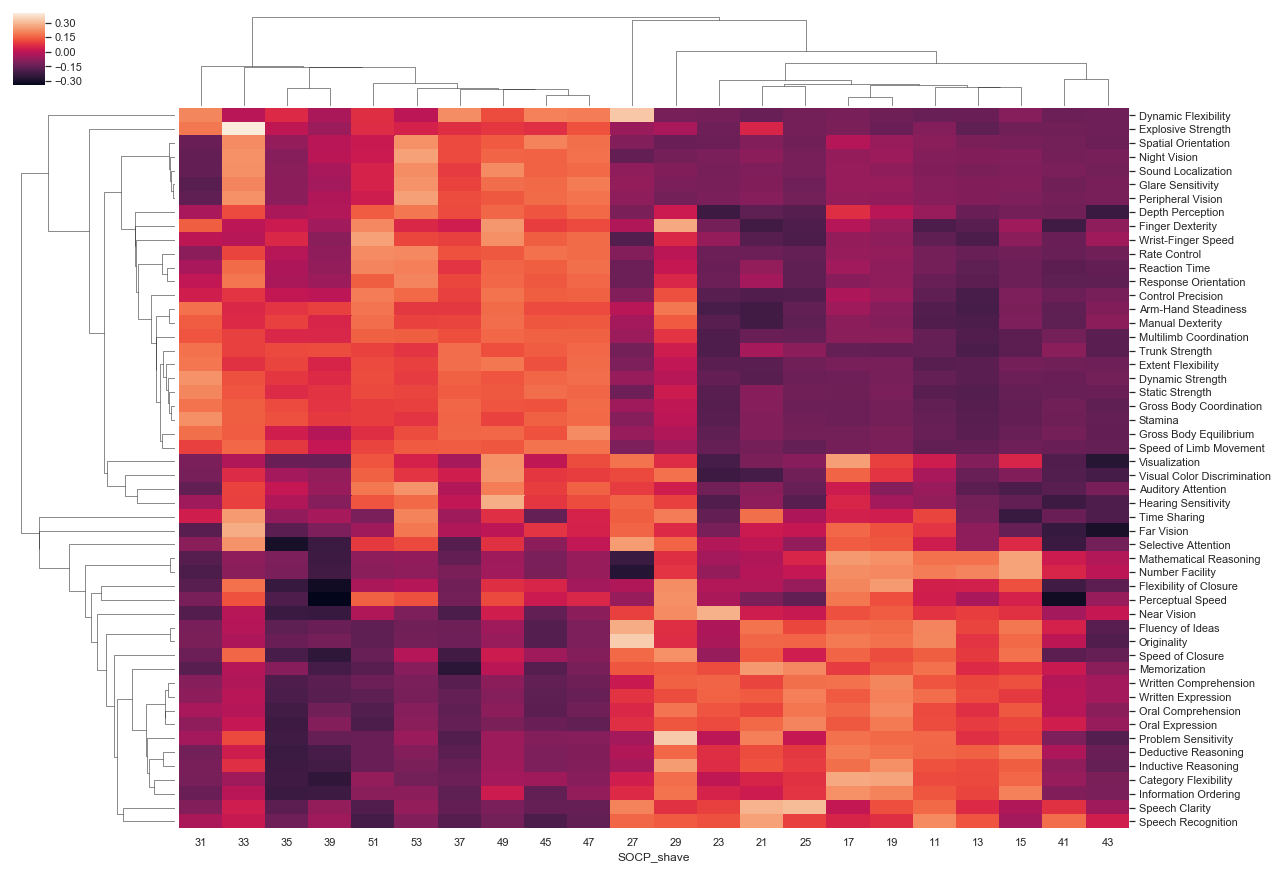

In [129]:
sns.clustermap(nrmcol(abm.apply(norm).T),figsize = (20,15),method='single',metric='cosine')

In [176]:
ab.nmatrix = ab.matrix.apply(lambda x: (x-x.min())/(1+ x.max()))

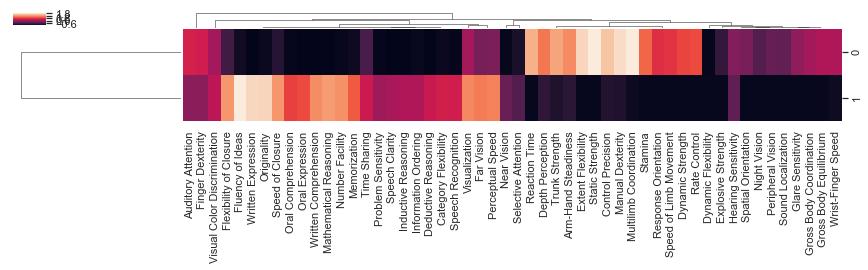

In [177]:
dab = Archetypes(ab.nmatrix,2)
dab.plot_features()

In [198]:
socp_counts = census.workers.groupby('SOCP_shave').count()[['RT']]

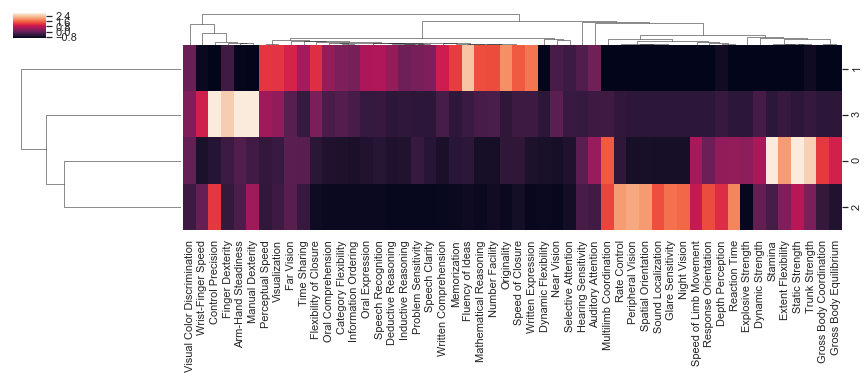

In [199]:
ab.matrixcnts = ab.nmatrix.merge(socp_counts,left_index = True,right_index = True)
ab.wmatrix = ab.matrixcnts.drop('RT',axis=1).multiply(ab.matrixcnts['RT'], axis="index")
dabwc = Archetypes(ab.wmatrix,4)
dabwc.plot_features()

In [173]:
np.dot(dabwc.fn.loc[0],dabwc.fn.loc[0])

1.0000000000000002

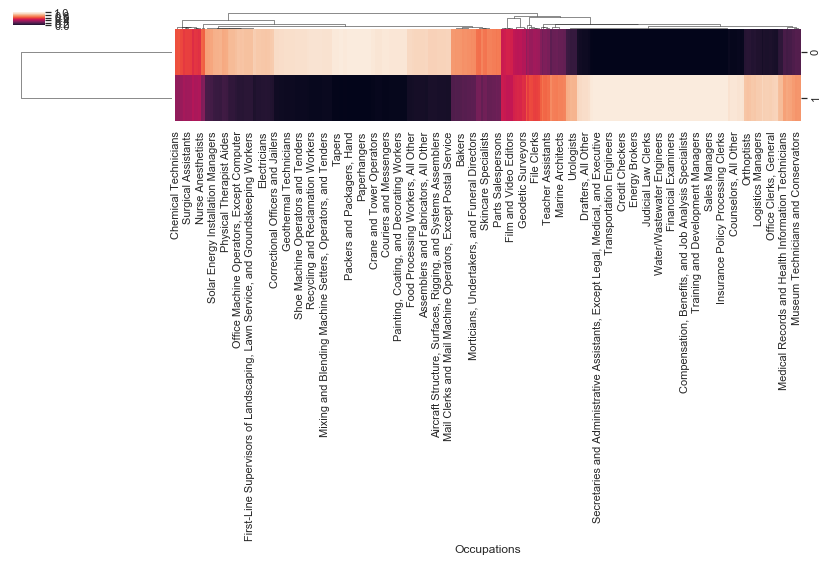

In [184]:
dabwc.plot_occupations(fig_scale = (1,25))

In [190]:
census.dear = census.workers[census.workers['DEAR']==1]

In [191]:
socp_counts = census.dear.groupby('SOCP_shave').count()[['RT']]

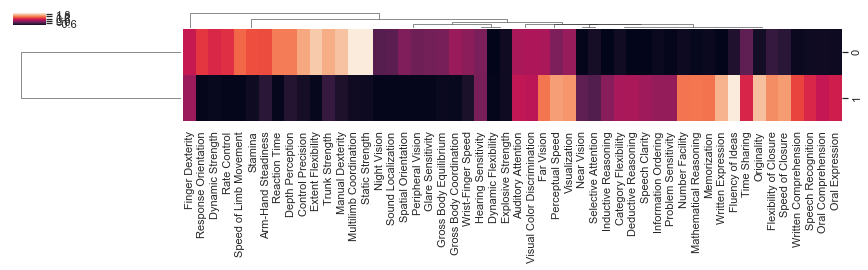

In [193]:
ab.matrixcnts = ab.nmatrix.merge(socp_counts,left_index = True,right_index = True)
ab.wmatrix = ab.matrixcnts.drop('RT',axis=1).multiply(ab.matrixcnts['RT'], axis="index")
dabwc = Archetypes(ab.wmatrix,2)
dabwc.plot_features()

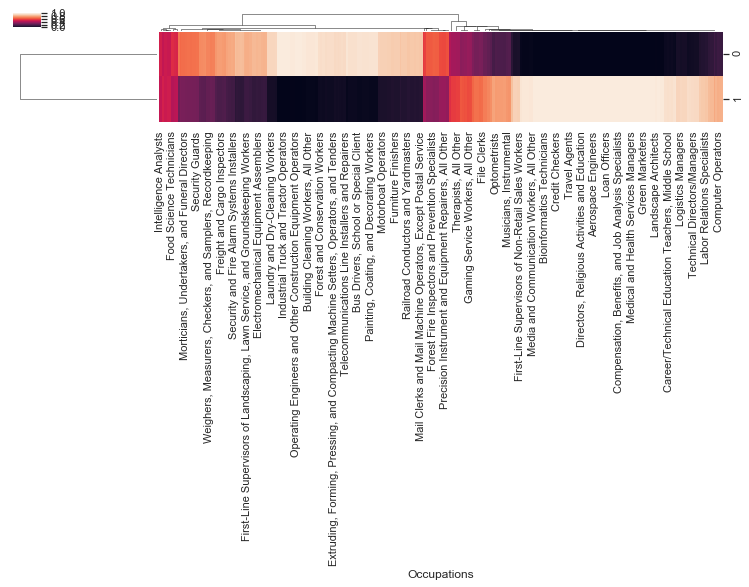

In [194]:
dabwc.plot_occupations(fig_scale = (1,25))

In [195]:
census.deye =census.workers[census.workers['DEYE']==1]

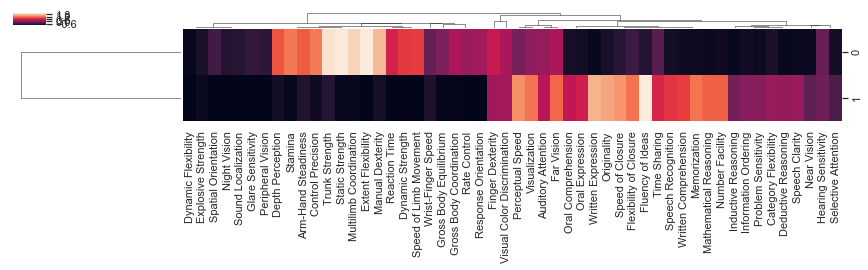

In [196]:
socp_counts = census.deye.groupby('SOCP_shave').count()[['RT']]
ab.matrixcnts = ab.nmatrix.merge(socp_counts,left_index = True,right_index = True)
ab.wmatrix = ab.matrixcnts.drop('RT',axis=1).multiply(ab.matrixcnts['RT'], axis="index")
dabwc = Archetypes(ab.wmatrix,2)
dabwc.plot_features()

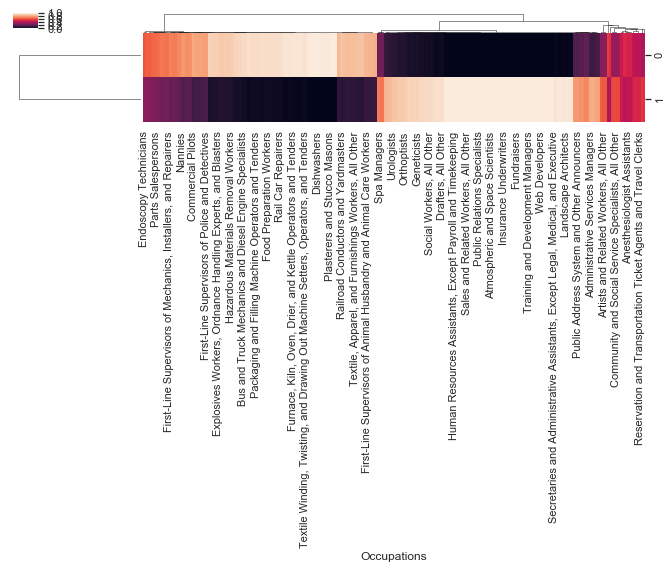

In [197]:
dabwc.plot_occupations(fig_scale = (1,25))

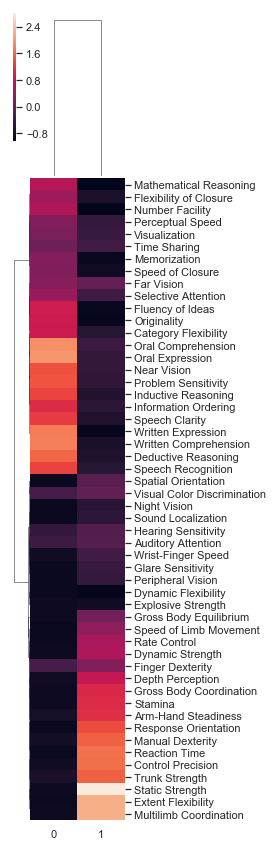

In [35]:
dabw.plot_features(method = 'single')

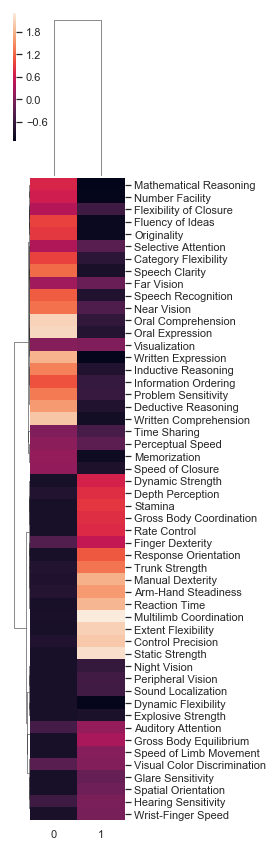

In [37]:
dab.plot_features(method = 'single')

In [33]:
nitr=10
n_arch = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,36,57]
arall = {}
arall_X = {}
arall_y = {} 
arall_xfit ={}
for n in n_arch:
    arall[n]=Archetypes(dall,n)
    arall_X[n] = arall[n].on.merge(census.occupations[['log FTE']],left_index = True,right_index = True)
    arall_y[n] = arall_X[n].pop('log FTE')
    arall_xfit[n] = Xfit(arall_X[n],arall_y[n],itr=nitr)

r2scores = pd.DataFrame([np.concatenate([pd.DataFrame(arall_xfit[n].y_predict[i]).T.apply(
    lambda ypred: r2_score(arall_xfit[n].y_test[i],ypred)) for i in range(nitr)]) for n in n_arch],
            index = n_arch).T
r2score = pd.DataFrame([r2scores.mean(),r2scores.std()],index = ['mean R^2 score','std']).T
r2score

,mean R^2 score,std
2,0.074774,0.095531
3,0.361043,0.105242
4,0.497219,0.125598
5,0.574247,0.068767
6,0.623821,0.077277
7,0.624137,0.073168
8,0.637912,0.062883
9,0.661386,0.067903
10,0.674321,0.059458
11,0.625670,0.064564


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Mean wages fitted to archetypes')

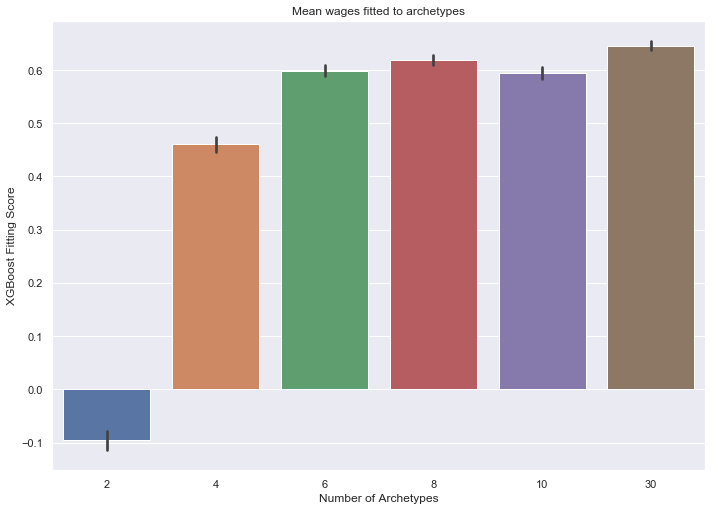

In [18]:
scrs = [arall_xfit[n].scores.values.flatten() for n in [2,4,6,8,10,30]]
dfscrs = pd.DataFrame(scrs, index = [2,4,6,8,10,30] ).T
sns.barplot(data = dfscrs)
plt.xlabel("Number of Archetypes")
plt.ylabel("XGBoost Fitting Score")
plt.title('Mean wages fitted to archetypes')

In [48]:
Svd(dall).o[:4]

SOCP_shave,11101,11102,11201,11202,11203,11301,11302,11303,11305,11306,...,53701,53702,53703,53704,53705,53706,53707,53708,53711,53712
0,-0.058644,0.063342,-0.033359,-0.002467,-0.091211,-0.078372,0.009909,0.000973,-0.071071,-0.047518,...,-0.078059,-0.049842,-0.021943,-0.080386,-0.049968,-0.067375,-0.024475,-0.037671,-0.033622,-0.081538
1,-0.053308,0.022312,-0.014530,-0.026010,-0.082914,-0.100204,-0.021137,-0.014802,-0.037172,-0.018731,...,-0.033663,0.004415,-0.026437,0.015254,0.040773,0.058132,0.022312,0.047597,-0.028881,-0.010592
2,-0.052280,0.070423,0.003269,-0.055404,-0.050370,-0.047213,0.073534,-0.029878,-0.010086,-0.063062,...,0.073976,-0.004426,0.058547,0.090264,0.085362,0.015756,0.037617,-0.022711,0.075842,0.130859
3,-0.053638,0.066268,-0.012738,-0.059086,-0.060607,-0.065975,0.019378,-0.022211,-0.035366,-0.071437,...,0.002119,-0.065527,-0.029875,-0.045060,-0.101225,-0.048341,-0.061550,-0.146794,-0.186438,-0.029152


In [35]:
class RXfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y, my_regressor, itr, xval) 
            does the following:
            1. SPLITS X and y into test and training sets.
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb  

    def __init__(self,X,samplx,y,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            X_train, X_test, y_train, y_test = train_test_split(X.sample(samplx,axis=1), y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
#       # feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval



In [41]:
nitr=30
n_arch = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,36,57]
rX = nrmcol(dall).merge(census.occupations[['log FTE']],left_index=True,right_index=True)
ry = rX.pop('log FTE')
xfit ={}
for n in n_arch:
    xfit[n] = RXfit(rX,n,ry,itr=nitr)

In [42]:
r2scores = pd.DataFrame([np.concatenate([pd.DataFrame(xfit[n].y_predict[i]).T.apply(
    lambda ypred: r2_score(xfit[n].y_test[i],ypred)) for i in range(nitr)]) for n in n_arch],
            index = n_arch).T
r2score = pd.DataFrame([r2scores.mean(),r2scores.std()],index = ['mean R^2 score','std']).T
r2score

,mean R^2 score,std
2,0.351952,0.215311
3,0.425419,0.145611
4,0.487224,0.174236
5,0.496552,0.126629
6,0.555050,0.094646
7,0.566543,0.080683
8,0.558904,0.098083
9,0.612561,0.073567
10,0.601332,0.068217
11,0.613848,0.070017


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Mean wages fit quality')

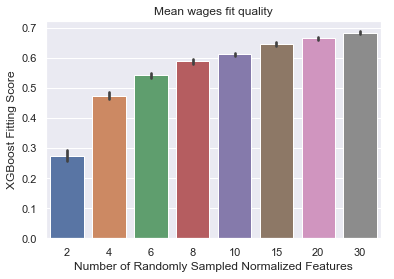

In [71]:
rscrs = [xfit[n].scores.values.flatten() for n in [2,4,6,8,10,15,20,30]]
rdfscrs = pd.DataFrame(rscrs, index = [2,4,6,8,10,15,20,30] ).T
sns.barplot(data = rdfscrs)
plt.xlabel("Number of Randomly Sampled Normalized Features")
plt.ylabel("XGBoost Fitting Score")
plt.title('Mean wages fit quality')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Mean wages fitted to archetypes')

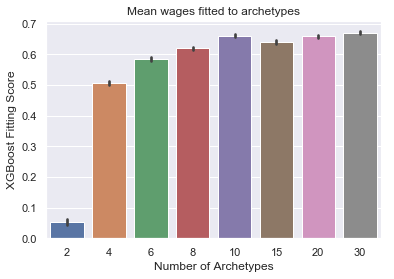

In [72]:
arall = {}
arall_X = {}
arall_y = {} 
arall_xfit ={}
for n in [2,4,6,8,10,15,20,30]:
    arall[n]=Archetypes(dall,n)
    arall_X[n] = arall[n].on.merge(census.occupations[['log FTE']],left_index = True,right_index = True)
    arall_y[n] = arall_X[n].pop('log FTE')
    arall_xfit[n] = Xfit(arall_X[n],arall_y[n],itr=200)
scrs = [arall_xfit[n].scores.values.flatten() for n in [2,4,6,8,10,15,20,30]]
dfscrs = pd.DataFrame(scrs, index = [2,4,6,8,10,15,20,30] ).T
sns.barplot(data = dfscrs)
plt.xlabel("Number of Archetypes")
plt.ylabel("XGBoost Fitting Score")
plt.title('Mean wages fitted to archetypes')

In [3]:
deaf_workers = census.workers[census.workers['DEAR']==1]

In [4]:
deaf_socp = deaf_workers.groupby('SOCP_shave')

In [5]:
deaf = deaf_socp.mean()[['log FTE']]
deaf['count'] = deaf_socp.count()['log FTE']

In [6]:
deaf20 = deaf[deaf['count']>20]

In [7]:
deafX = ab.matrix.merge(deaf20,left_index = True, right_index = True)

In [8]:
dfx = deafX.drop(columns = ['log FTE','count'])

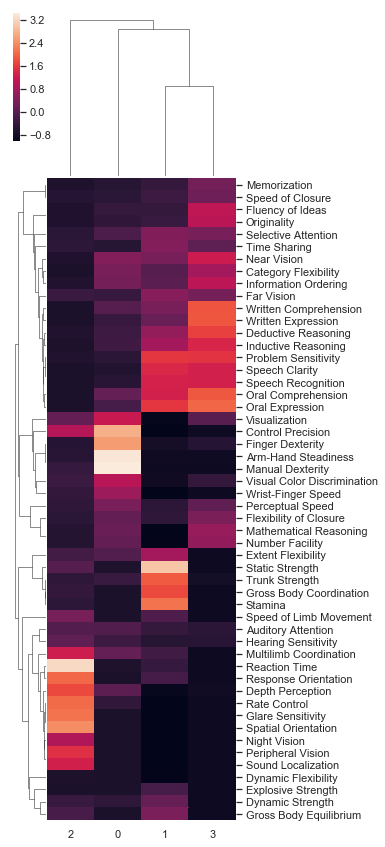

In [9]:
Archetypes(dfx,4).plot_features()

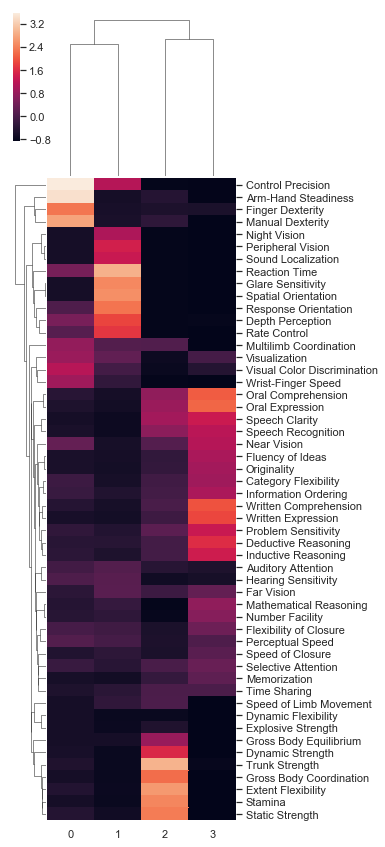

In [102]:
Archetypes(ab.matrix,4).plot_features()

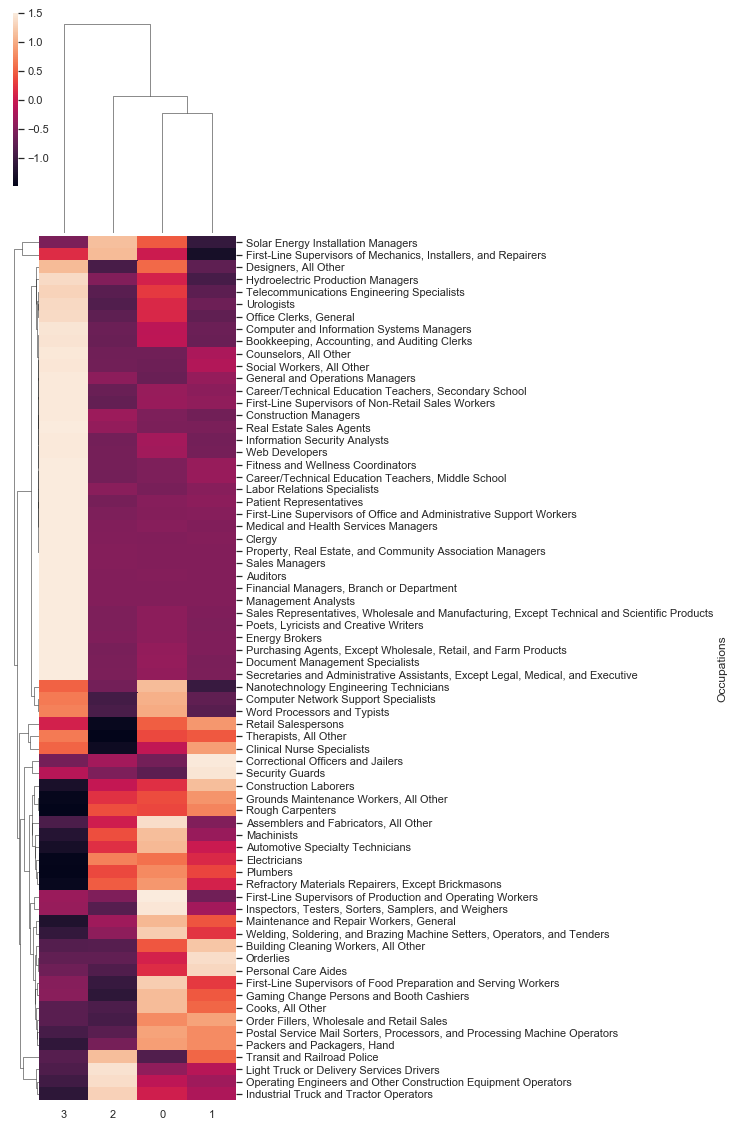

In [10]:
Archetypes(dfx,4).plot_occupations()

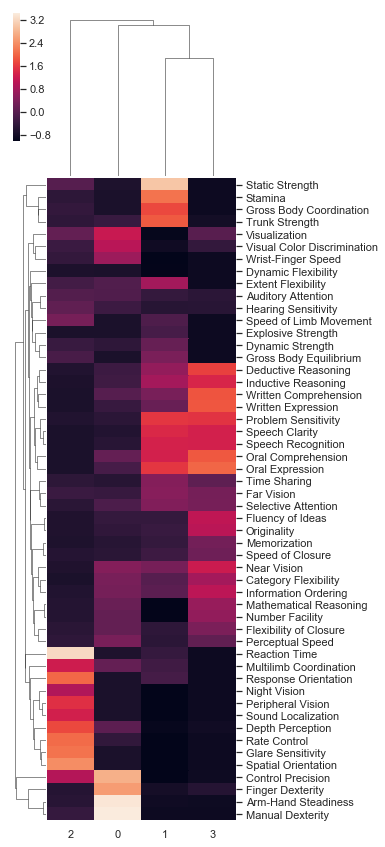

In [107]:
Archetypes(dfx,4).plot_features()

In [131]:
fig_scale = (1,3.5)
metric = 'cosine'
cluster = (True,False)

In [136]:
self = Archetypes(dfx,4)

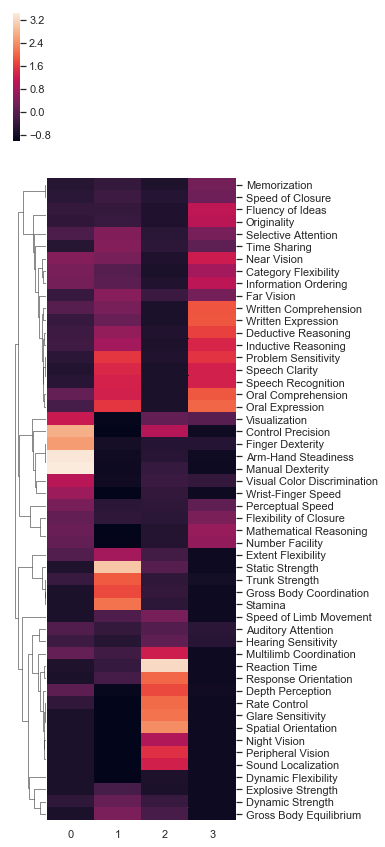

In [137]:
sns.clustermap(self.fn.apply(lambda x: x**2).T,figsize=(
            self.n/fig_scale[0], self.X.shape[1]/fig_scale[1]),method = 'single',z_score = 1,metric = metric,
              row_cluster = cluster[0],col_cluster = cluster[1])

In [ ]:
ab.matrix

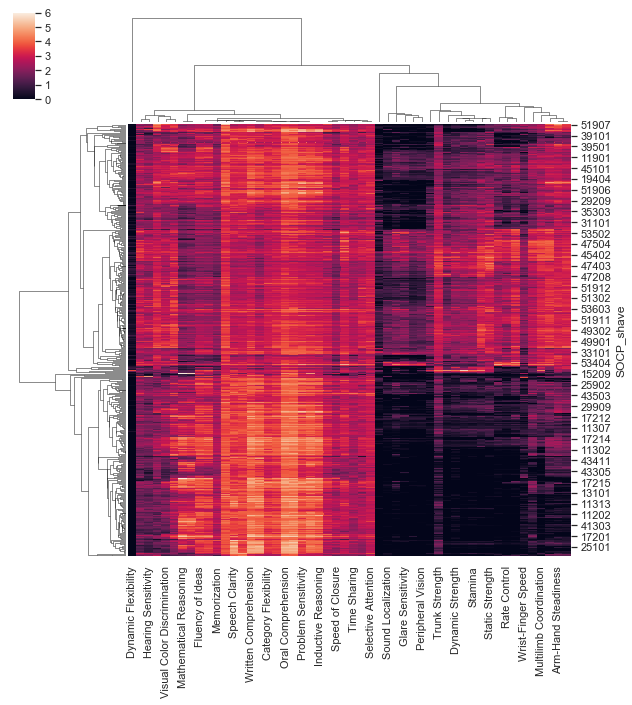

In [143]:
sns.clustermap(ab.matrix,metric = 'cosine')

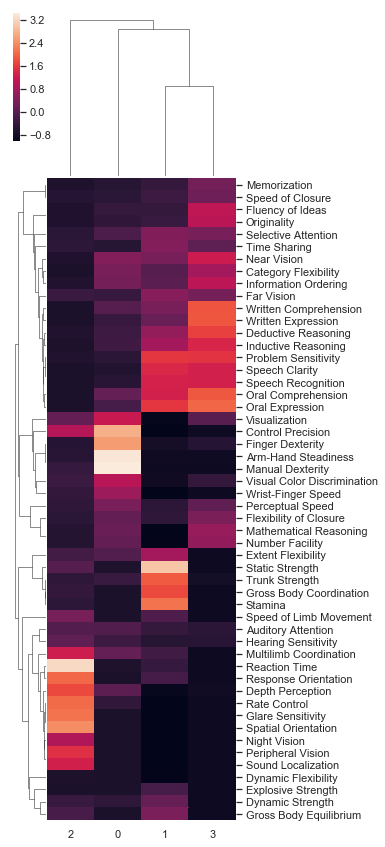

In [125]:
sns.clustermap(self.fn.apply(lambda x: x**2).T,figsize=(
            self.n/fig_scale[0], self.X.shape[1]/fig_scale[1]),method = 'single',z_score = 1,metric = 'cosine')

In [161]:
abmat = ab.matrix.copy().apply(norm,axis=1)

In [162]:
abmat.index = abmat.index.map(lookup_title)

In [163]:
abmat.max()

Arm-Hand Steadiness            1.919132
Auditory Attention             1.393208
Category Flexibility           1.588846
Control Precision              2.063672
Deductive Reasoning            2.064715
Depth Perception               2.012466
Dynamic Flexibility            0.834613
Dynamic Strength               1.231502
Explosive Strength             0.668997
Extent Flexibility             2.066617
Far Vision                     2.201432
Finger Dexterity               1.823969
Flexibility of Closure         1.434008
Fluency of Ideas               1.403692
Glare Sensitivity              1.403430
Gross Body Coordination        2.322948
Gross Body Equilibrium         1.948159
Hearing Sensitivity            2.141784
Inductive Reasoning            1.814901
Information Ordering           1.610881
Manual Dexterity               2.484742
Mathematical Reasoning         2.884296
Memorization                   1.091183
Multilimb Coordination         2.012466
Near Vision                    2.236460


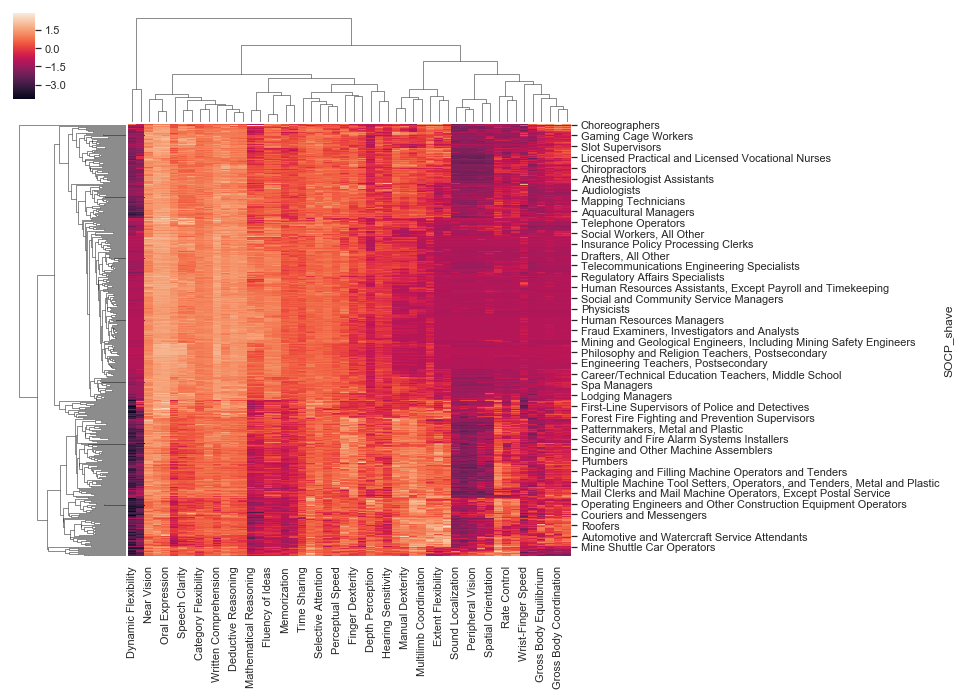

In [165]:
sns.clustermap(abmat)

In [22]:
# edu = from_onet('Education, Training, and Experience')
# ed = {}
# ncols0 = edu.shape[1]
# for element in edu['Element Name'].unique():
#     ed[element] = edu[edu['Element Name']==element]
#     ed[element] = pd.get_dummies(ed[element],columns = ['Category'],prefix = element)
#     ncols = ed[element].shape[1] - ncols0 + 1
#ed['Required Level of Education']['Data Value']